In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import cmcrameri.cm as cm

from tqdm import tqdm
from scipy.interpolate import UnivariateSpline
from utils import ELFData, ELFModel

## Load and filter data

In [2]:
# Perform center crop
center = True

In [3]:
# Load labeled data
labeled = ELFData()
labeled.load_processed(dirname='data/labeled', structure=False)
print('Number of examples:', len(labeled.data))
labeled.data.head()

Parse profiles: 100%|██████████| 2376/2376 [00:00<00:00, 17515.12it/s]          

Number of examples: 2376


,formula,label,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,edge_dst,l,r_diff,g_diff,specie_src,specie_dst,mixed,id
0,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.001232828834182255, 0.001087356613359765, 0...",1.43,0,4,1.913597,0.6,2,Al,N,False,0
1,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.001232828834182255, 0.0013045701442416335, ...",1.43,0,6,1.901737,0.6,2,Al,N,False,0
2,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.001232828834182255, 0.0010438078812688811, ...",1.43,0,7,1.901727,0.6,2,Al,N,False,0
3,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.0014376577124132356, 0.0012458509658890753,...",1.43,1,5,1.913597,0.6,2,Al,N,False,0
4,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.0014376577124132356, 0.0012551757001977302,...",1.43,1,6,1.901721,0.6,2,Al,N,False,0


In [4]:
# Center crop
if center:
    dx = len(labeled.data.iloc[0]['elf'])//4
    labeled.data['elf'] = labeled.data['elf'].apply(lambda x: x[dx:-dx])

In [5]:
# Sort and filter labeled data
labeled.data = labeled.data[~labeled.data['mixed']].reset_index(drop=True)
labeled.get_pdf_cdf()
labeled.sort_by_cdf()
labeled.drop_duplicates(column='elf_srt', precision=1e-6)
print('Number of examples:', len(labeled.data_nodup), '/', len(labeled.data))
labeled.data_nodup.head()

Drop duplicates: 100%|██████████| 2270/2270 [00:00<00:00, 428529.57it/s]        


Number of examples: 1064 / 2270


,formula,label,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,...,specie_src,specie_dst,mixed,id,A,pdf,cdf,elf_srt,pdf_srt,cdf_srt
0,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.0766052136614351, 0.13362691365696633, 0.19...",1.43,...,Al,N,False,0,11.730584,"[0.006530383470247573, 0.011391326339514642, 0...","[0.006530383470247573, 0.017921709809762217, 0...","[0.6865670045608814, 0.7126530967818006, 0.732...","[0.05852794612149087, 0.06075171363417916, 0.0...","[0.05852794612149087, 0.11927965975567004, 0.1..."
1,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.19028924682758955, 0.2650648239269672, 0.34...",1.43,...,Al,N,False,0,12.718895,"[0.014961146144839114, 0.02084023997541216, 0....","[0.014961146144839114, 0.03580138612025127, 0....","[0.6164678763893062, 0.6666937452334862, 0.699...","[0.0484686662332293, 0.05241758387601199, 0.05...","[0.0484686662332293, 0.1008862501092413, 0.155..."
2,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.1349782998882327, 0.2005701303393725, 0.290...",1.43,...,Al,N,False,0,12.413687,"[0.010873344800528506, 0.016157176269613594, 0...","[0.010873344800528506, 0.027030521070142102, 0...","[0.6470326590413169, 0.6895848649738181, 0.710...","[0.05212252047021359, 0.055550366335143736, 0....","[0.05212252047021359, 0.10767288680535733, 0.1..."
3,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.07142745656532536, 0.1258184344786082, 0.18...",1.43,...,Al,N,False,0,11.619422,"[0.006147247104570372, 0.010828287107533214, 0...","[0.006147247104570372, 0.016975534212103585, 0...","[0.6869881377044609, 0.7120131149963426, 0.731...","[0.05912412457967944, 0.06127784426391273, 0.0...","[0.05912412457967944, 0.12040196884359217, 0.1..."
4,Al2N2,covalent,1.25,0.65,1.61,3.04,13,15,"[0.06665061584616219, 0.12714917280029964, 0.1...",1.43,...,Al,N,False,0,11.570416,"[0.005760433759348834, 0.01098916158798402, 0....","[0.005760433759348834, 0.016749595347332856, 0...","[0.5963516329473, 0.6415048740955936, 0.682551...","[0.05154107033011363, 0.05544354371843157, 0.0...","[0.05154107033011363, 0.1069846140485452, 0.16..."


In [6]:
# Load unlabeled data
unlabeled = ELFData()
unlabeled.load_processed(dirname='data/unlabeled', structure=False)
print('Number of examples:', len(unlabeled.data))
unlabeled.data.head()

Parse profiles: 100%|██████████| 320585/320585 [00:19<00:00, 16820.49it/s]      


Number of examples: 320585


,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,edge_dst,l,r_diff,g_diff,specie_src,specie_dst,mixed,id
0,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,4,3.812422,1.2,16,K,Cl,False,0
1,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,5,3.812422,1.2,16,K,Cl,False,0
2,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,6,3.812422,1.2,16,K,Cl,False,0
3,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.002364966985433359, ...",2.34,0,7,3.812422,1.2,16,K,Cl,False,0
4,100,2.2,1.0,0.82,3.16,1,17,"[0.0015327815625000077, 0.0070974035970135085,...",2.34,0,8,3.812422,1.2,16,K,Cl,False,0


In [7]:
# Center crop
if center:
    dx = len(unlabeled.data.iloc[0]['elf'])//4
    unlabeled.data['elf'] = unlabeled.data['elf'].apply(lambda x: x[dx:-dx])

In [8]:
# Sort and filter unlabeled data
unlabeled.data = unlabeled.data[~unlabeled.data['mixed']].reset_index(drop=True)
unlabeled.get_pdf_cdf()
unlabeled.sort_by_cdf()
unlabeled.drop_duplicates(column='elf_srt', precision=1e-6)
print('Number of examples:', len(unlabeled.data_nodup), '/', len(unlabeled.data))
unlabeled.data_nodup.head()

Drop duplicates: 100%|██████████| 279511/279511 [00:00<00:00, 443021.85it/s]    


Number of examples: 156821 / 279511


,formula,r_src,r_dst,e_src,e_dst,g_src,g_dst,elf,e_diff,edge_src,...,specie_src,specie_dst,mixed,id,A,pdf,cdf,elf_srt,pdf_srt,cdf_srt
0,100,2.20,1.0,0.82,3.16,1,17,"[0.2836648820223565, 0.26950409607068304, 0.21...",2.34,0,...,K,Cl,False,0,5.582426,"[0.05081391150628384, 0.048277238940128635, 0....","[0.05081391150628384, 0.09909115044641248, 0.1...","[0.7455893527640319, 0.7108431083288929, 0.664...","[0.13356010487189254, 0.12733588502023072, 0.1...","[0.13356010487189254, 0.26089598989212326, 0.3..."
1,100,2.20,1.0,0.82,3.16,1,17,"[0.2260318457264771, 0.16062050292447833, 0.08...",2.34,0,...,K,Cl,False,0,6.125955,"[0.03689740731760198, 0.026219668741431404, 0....","[0.03689740731760198, 0.06311707605903338, 0.0...","[0.7686432045114789, 0.7525041401522609, 0.723...","[0.12547321067796205, 0.12283867203818265, 0.1...","[0.12547321067796205, 0.24831188271614468, 0.3..."
2,100,2.20,1.0,0.82,3.16,1,17,"[0.26519790183874503, 0.28334966971743014, 0.2...",2.34,1,...,K,Cl,False,0,4.879574,"[0.054348577974015495, 0.058068527359289315, 0...","[0.054348577974015495, 0.11241710533330482, 0....","[0.6976173704146346, 0.6481706560428522, 0.588...","[0.14296686281877724, 0.1328334545491004, 0.12...","[0.14296686281877724, 0.27580031736787763, 0.3..."
3,100,2.20,1.0,0.82,3.16,1,17,"[0.28281808556454047, 0.2775541844733199, 0.23...",2.34,1,...,K,Cl,False,0,5.589022,"[0.05060242973644947, 0.049660601053264634, 0....","[0.05060242973644947, 0.1002630307897141, 0.14...","[0.7426123472588098, 0.7064005554867913, 0.659...","[0.13286982354248436, 0.12639073064742853, 0.1...","[0.13286982354248436, 0.2592605541899129, 0.37..."
4,100,1.55,1.0,1.78,3.16,13,17,"[0.5166650473513822, 0.5032742443246504, 0.478...",1.38,2,...,In,Cl,False,0,10.443076,"[0.049474413427305006, 0.04819214723092813, 0....","[0.049474413427305006, 0.09766656065823313, 0....","[0.6618392073066932, 0.6741400048923618, 0.674...","[0.06337588875529644, 0.06455377905067977, 0.0...","[0.06337588875529644, 0.1279296678059762, 0.19..."


## Analyze data

### Bond length and area statistics

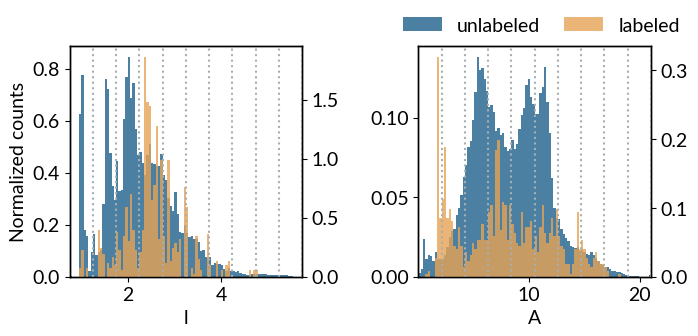

In [9]:
fig, ax = plt.subplots(1,2, figsize=(7.5,3))
fig.subplots_adjust(wspace=0.5)

_ax = ax[0].twinx()
_, bins, _ = ax[0].hist(unlabeled.data_nodup['l'], bins=100, density=True, color=unlabeled.palette[0], alpha=0.8)
_ax.hist(labeled.data_nodup['l'], bins=bins, density=True, color=unlabeled.palette[2], alpha=0.8)
_, bins = np.histogram(unlabeled.data_nodup['l'], bins=10)
ax[0].set_xlim([bins[0], bins[-1]])
ax[0].set_xlabel('l')
ax[0].set_ylabel('Normalized counts')
for k in bins:
    _ax.axvline(k, color=unlabeled.palette[1], ls=':')

_ax = ax[1].twinx()
_, bins, _ = ax[1].hist(unlabeled.data_nodup['A'], bins=100, density=True, color=unlabeled.palette[0], alpha=0.8,
                        label='unlabeled')
_ax.hist(labeled.data_nodup['A'], bins=bins, density=True, color=unlabeled.palette[2], alpha=0.8, label='labeled')
_, bins = np.histogram(unlabeled.data_nodup['A'], bins=10)
ax[1].set_xlim([bins[0], bins[-1]])
ax[1].set_xlabel('A')
ax[1].legend(frameon=False, loc='upper right', bbox_to_anchor=(0.6,1.2))
_ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.2,1.2))
for k in bins:
    _ax.axvline(k, color=unlabeled.palette[1], ls=':')

In [10]:
n_bins = 10
_, bins = np.histogram(unlabeled.data_nodup['l'], bins=n_bins)
labeled.data_nodup['l_bin'] = np.digitize(labeled.data_nodup['l'], bins[:-1], right=False).tolist()

_, bins = np.histogram(unlabeled.data_nodup['A'], bins=n_bins)
labeled.data_nodup['A_bin'] = np.digitize(labeled.data_nodup['A'], bins[:-1], right=False).tolist()

## Featurize data

### PCA

In [11]:
n_classes = 4
n_components = 12
target = 0.995

#### Sorted ELF profiles

Number of components: 5


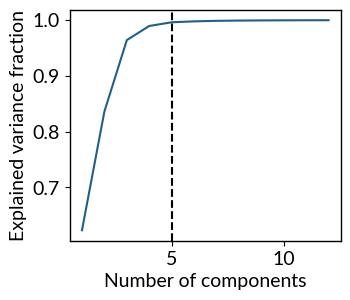

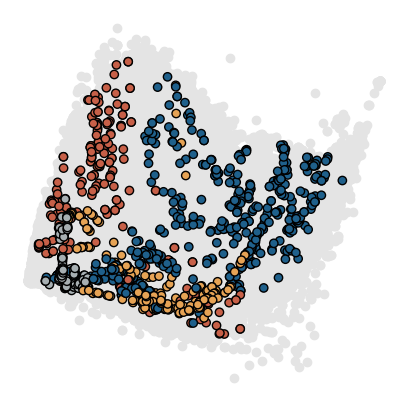

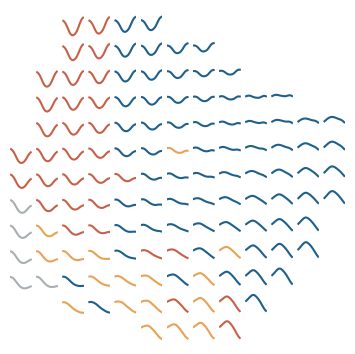

In [12]:
model = ELFModel(n_classes)

unlabeled.data_nodup = model.pca_fit(unlabeled.data_nodup, n_components, column='elf_srt')
labeled.data_nodup = model.pca_transform(labeled.data_nodup)
fig = model.plot_evr(target=target)

y = model.bond_to_float(labeled.data_nodup['label'].tolist())
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.dmap)

fig = model.plot_profiles(n=15, axes=[0,1], y=y, cmap=model.dmap)

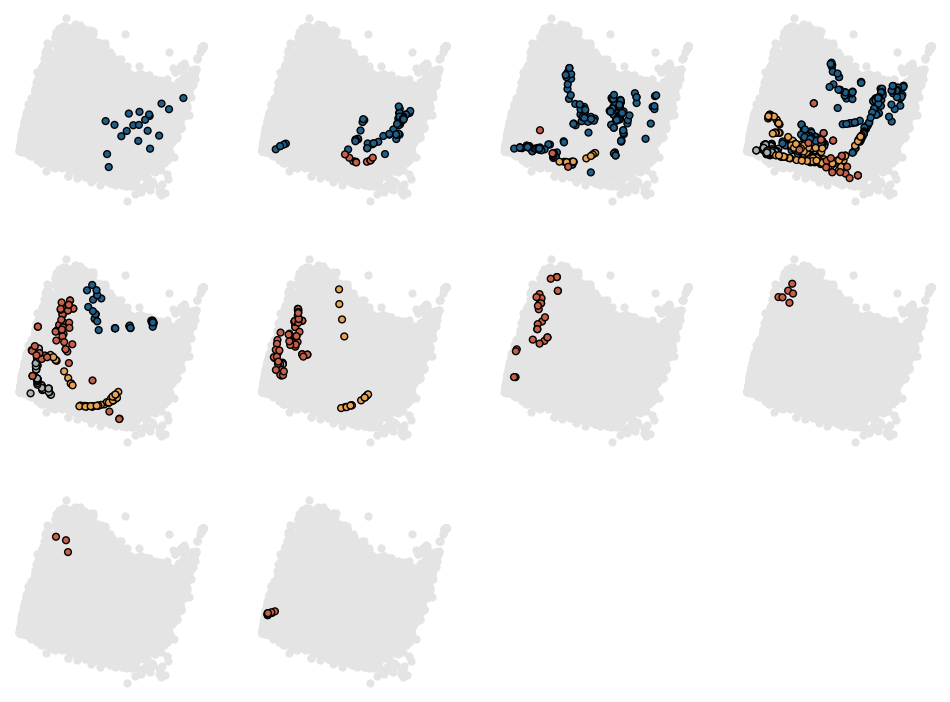

In [13]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

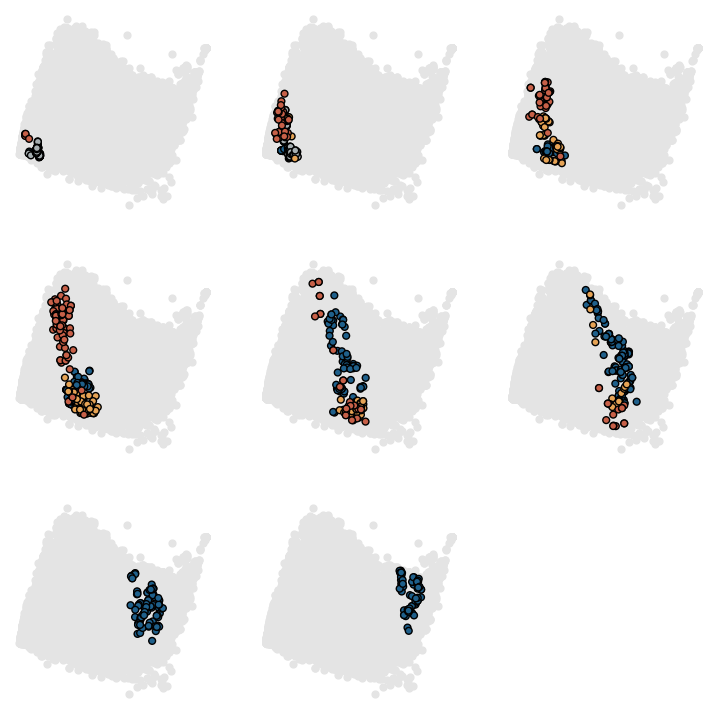

In [14]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1-2)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1-2)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

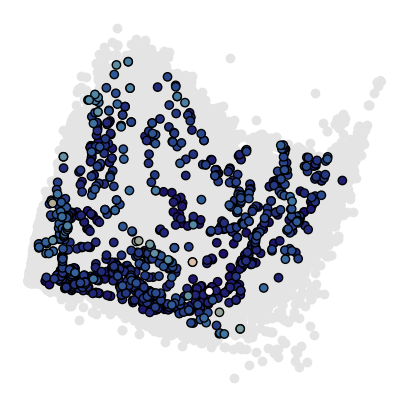

,formula,d_elf_srt_euc,label,l,specie_src,specie_dst
417,H2S_vdw,0.203500,vdw,2.691945,H,S
406,H2S_vdw,0.203500,vdw,2.691945,S,H
759,NbOCl3_cov,0.216900,covalent,2.575549,Cl,Nb
401,H2S_vdw,0.230114,vdw,2.691945,S,H
749,NbOCl3_cov,0.232239,covalent,2.575549,Cl,Nb
434,H4C_vdw,0.256297,vdw,3.134020,C,H
419,H2S_vdw,0.283448,vdw,2.691945,H,S
405,H2S_vdw,0.283448,vdw,2.691945,S,H
418,H2S_vdw,0.338033,vdw,2.691945,H,S
402,H2S_vdw,0.338033,vdw,2.691945,S,H


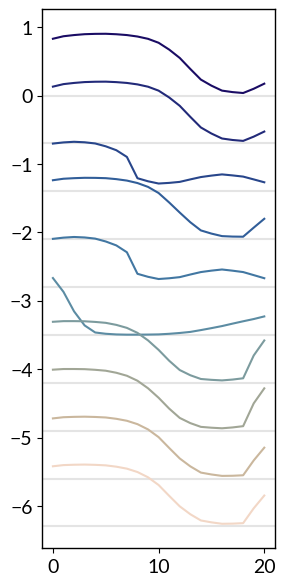

In [15]:
labeled.get_distances(ref=unlabeled, data='data_nodup', column='elf_srt', metric='euclidean')
unlabeled.get_distances(ref=labeled, data='data_nodup', column='elf_srt', metric='euclidean')

y = labeled.data_nodup['d_elf_srt_euc'].values
order = np.argsort(y)
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.cmap, order=order)
plt.show()

n = 10
norm = plt.Normalize(vmin=0, vmax=n)
fig, ax = plt.subplots(figsize=(3,7))
for i, idx in enumerate(order[-n:]):
    ax.plot(labeled.data_nodup.iloc[idx]['elf_srt']  - 0.7*i, color=model.cmap(norm(i)))
    ax.axhline(-0.7*i, color=model.bkg, zorder=-i)
    
labeled.data_nodup.iloc[order[-n:]][['formula', 'd_elf_srt_euc', 'label', 'l', 'specie_src', 'specie_dst']]

#### Sorted PDFs of ELF profiles

Number of components: 6


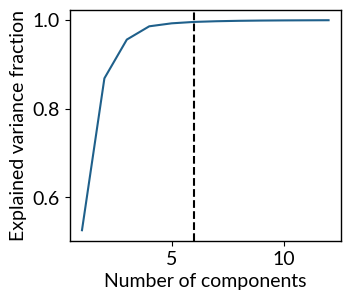

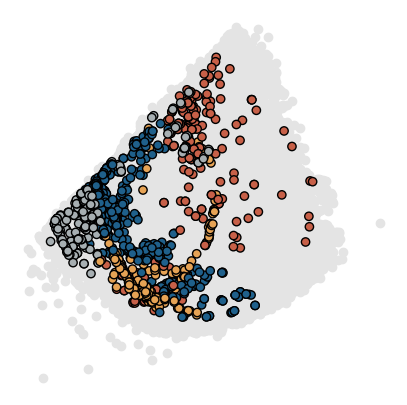

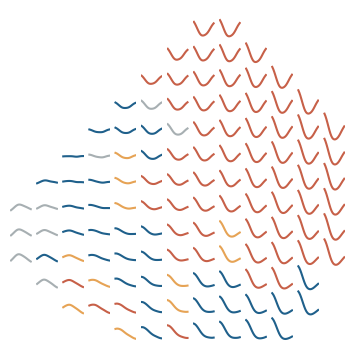

In [16]:
model = ELFModel(n_classes)

unlabeled.data_nodup = model.pca_fit(unlabeled.data_nodup, n_components, column='pdf_srt')
labeled.data_nodup = model.pca_transform(labeled.data_nodup)
fig = model.plot_evr(target=target)

y = model.bond_to_float(labeled.data_nodup['label'].tolist())
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.dmap)

fig = model.plot_profiles(n=15, axes=[0,1], y=y, cmap=model.dmap)

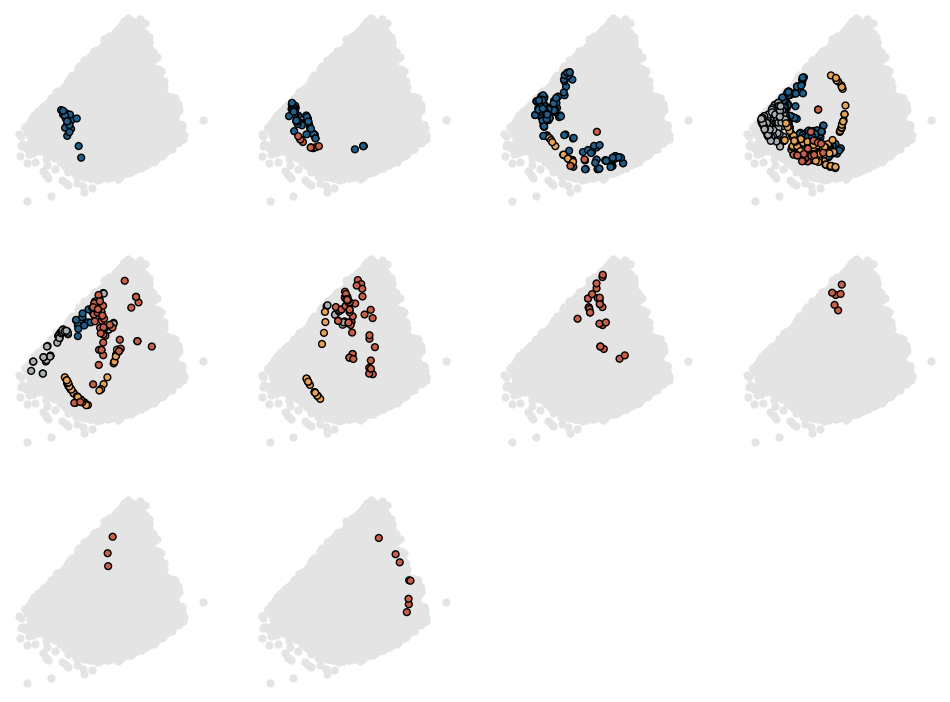

In [17]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

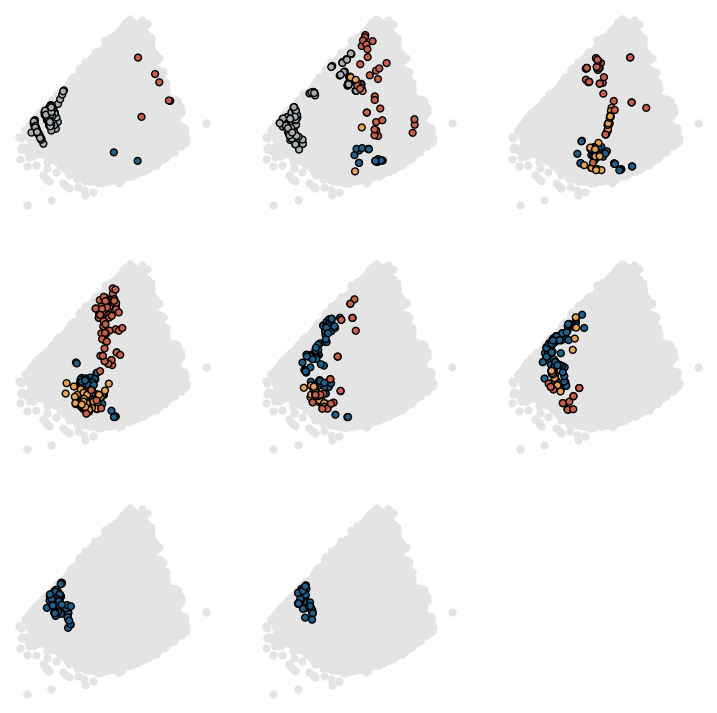

In [18]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1-2)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1-2)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

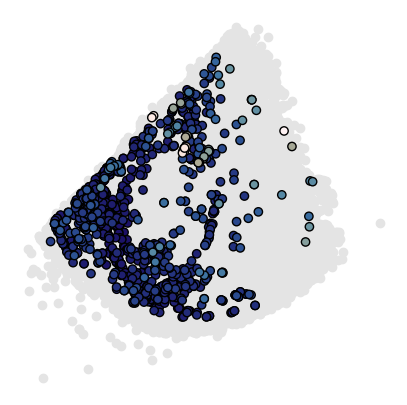

,formula,d_pdf_srt_euc,label,l,specie_src,specie_dst
1034,Zr2,0.037425,metallic,3.239225,Zr,Zr
1057,Zr2,0.037525,metallic,3.239226,Zr,Zr
1036,Zr2,0.038509,metallic,3.239235,Zr,Zr
1055,Zr2,0.039212,metallic,3.239225,Zr,Zr
1040,Zr2,0.039299,metallic,3.239238,Zr,Zr
1056,Zr2,0.040495,metallic,3.239235,Zr,Zr
1041,Zr2,0.040716,metallic,3.239235,Zr,Zr
1061,Zr2,0.040911,metallic,3.239238,Zr,Zr
1062,Zr2,0.040987,metallic,3.239235,Zr,Zr
654,MoSTe_vdw,0.042628,vdw,6.215416,Mo,S


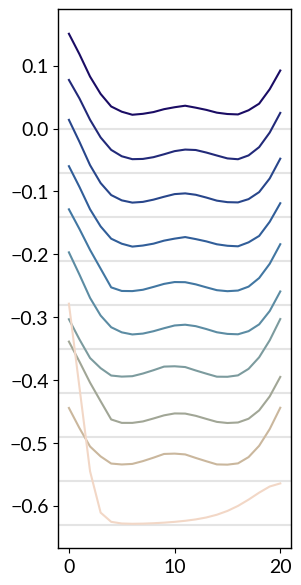

In [19]:
labeled.get_distances(ref=unlabeled, data='data_nodup', column='pdf_srt', metric='euclidean')
unlabeled.get_distances(ref=labeled, data='data_nodup', column='pdf_srt', metric='euclidean')

y = labeled.data_nodup['d_pdf_srt_euc'].values
order = np.argsort(y)
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.cmap, order=order)
plt.show()

n = 10
norm = plt.Normalize(vmin=0, vmax=n)
fig, ax = plt.subplots(figsize=(3,7))
for i, idx in enumerate(order[-n:]):
    ax.plot(labeled.data_nodup.iloc[idx]['pdf_srt']  - 0.07*i, color=model.cmap(norm(i)))
    ax.axhline(-0.07*i, color=model.bkg, zorder=-i)
    
labeled.data_nodup.iloc[order[-n:]][['formula', 'd_pdf_srt_euc', 'label', 'l', 'specie_src', 'specie_dst']]

#### Sorted PDFs of ELF profiles normalized by bond length

Number of components: 5


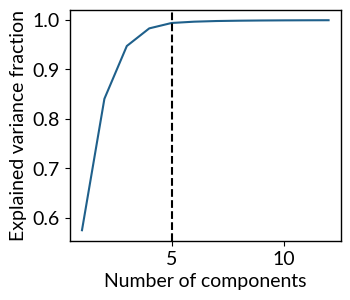

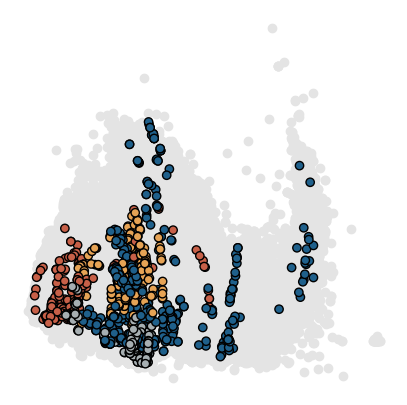

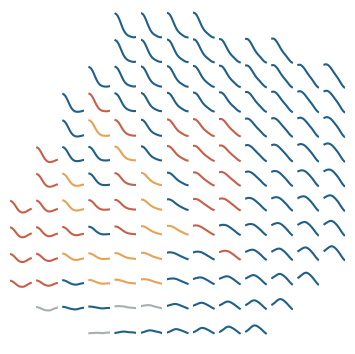

In [20]:
model = ELFModel(n_classes)

unlabeled.data_nodup['pdf-l_srt'] = unlabeled.data_nodup[['pdf_srt', 'l']].apply(
    lambda x: x.pdf_srt/(x.l/len(x.pdf_srt)), axis=1)
labeled.data_nodup['pdf-l_srt'] = labeled.data_nodup[['pdf_srt', 'l']].apply(
    lambda x: x.pdf_srt/(x.l/len(x.pdf_srt)), axis=1)

unlabeled.data_nodup = model.pca_fit(unlabeled.data_nodup, n_components, column='pdf-l_srt')
labeled.data_nodup = model.pca_transform(labeled.data_nodup)
fig = model.plot_evr(target=target)

y = model.bond_to_float(labeled.data_nodup['label'].tolist())
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.dmap)

fig = model.plot_profiles(n=15, axes=[0,1], y=y, cmap=model.dmap)

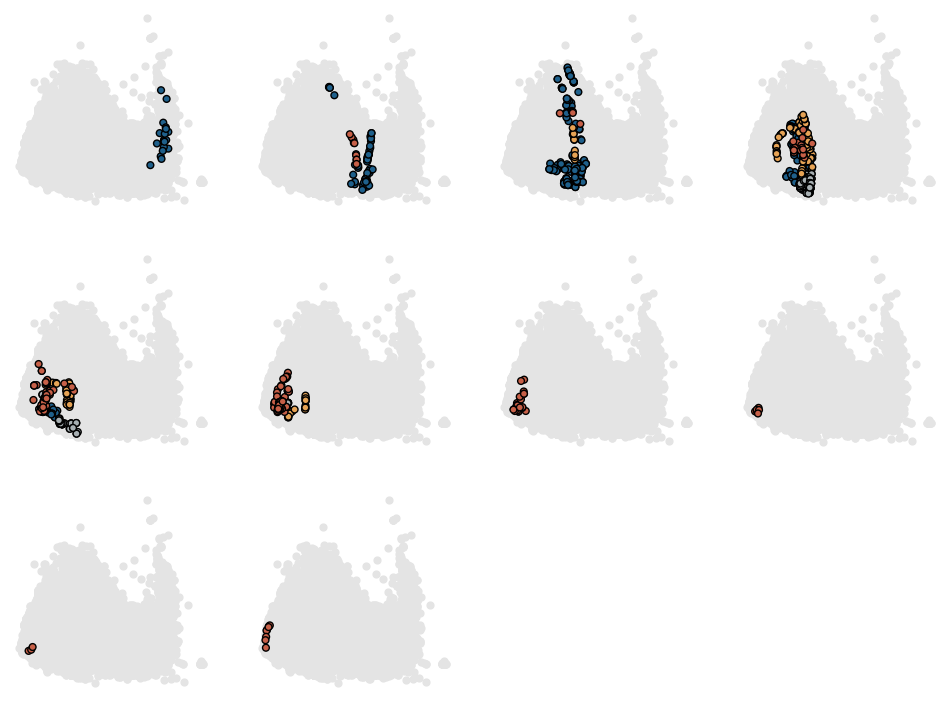

In [21]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

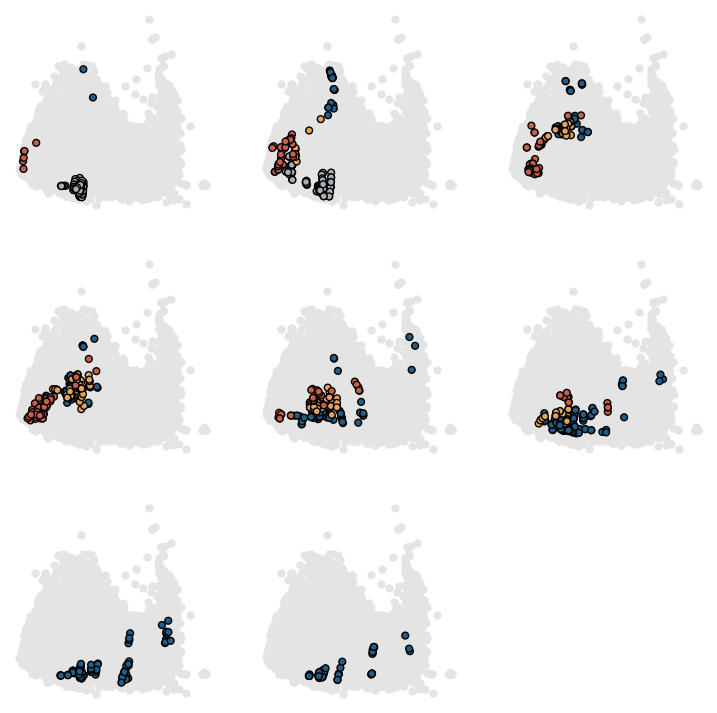

In [22]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1-2)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1-2)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

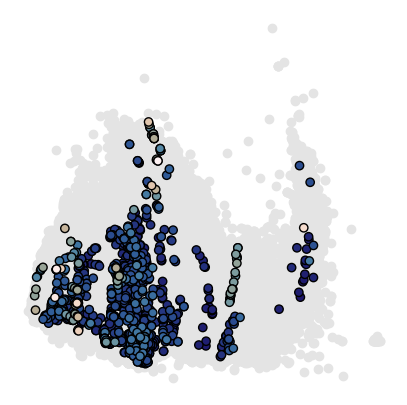

,formula,d_pdf-l_srt_euc,label,l,specie_src,specie_dst
1062,Zr2,0.280925,metallic,3.239235,Zr,Zr
1040,Zr2,0.291688,metallic,3.239238,Zr,Zr
1061,Zr2,0.292020,metallic,3.239238,Zr,Zr
442,HF_cov,0.294185,covalent,0.956268,H,F
437,H4C_vdw,0.296829,vdw,2.955234,H,H
439,H4C_vdw,0.296829,vdw,2.955234,H,H
432,H4C_vdw,0.308928,vdw,3.134020,C,H
434,H4C_vdw,0.312093,vdw,3.134020,C,H
206,CuH,0.319191,covalent,1.734707,H,Cu
202,CuH,0.319191,covalent,1.734707,Cu,H


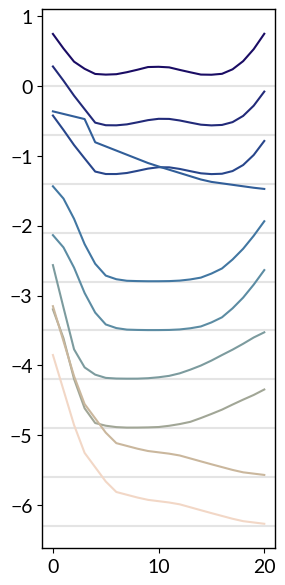

In [23]:
labeled.get_distances(ref=unlabeled, data='data_nodup', column='pdf-l_srt', metric='euclidean')
unlabeled.get_distances(ref=labeled, data='data_nodup', column='pdf-l_srt', metric='euclidean')

y = labeled.data_nodup['d_pdf-l_srt_euc'].values
order = np.argsort(y)
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.cmap, order=order)
plt.show()

n = 10
norm = plt.Normalize(vmin=0, vmax=n)
fig, ax = plt.subplots(figsize=(3,7))
for i, idx in enumerate(order[-n:]):
    ax.plot(labeled.data_nodup.iloc[idx]['pdf-l_srt']  - 0.7*i, color=model.cmap(norm(i)))
    ax.axhline(-0.7*i, color=model.bkg, zorder=-i)
    
labeled.data_nodup.iloc[order[-n:]][['formula', 'd_pdf-l_srt_euc', 'label', 'l', 'specie_src', 'specie_dst']]

#### Sorted CDFs of ELF profiles

Number of components: 3


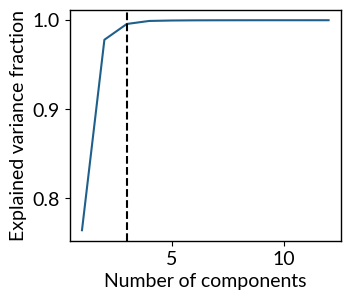

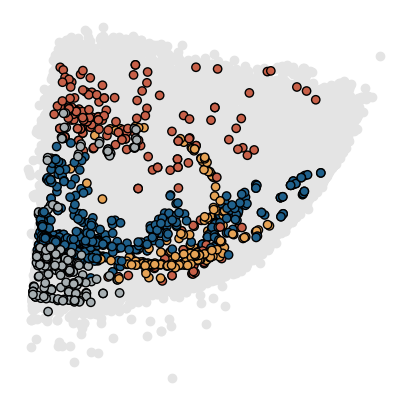

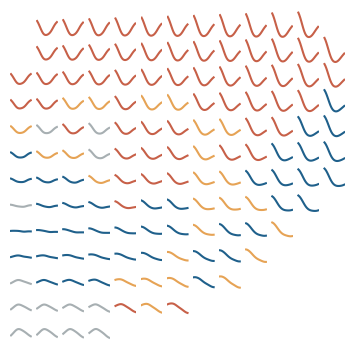

In [24]:
model = ELFModel(n_classes)

unlabeled.data_nodup = model.pca_fit(unlabeled.data_nodup, n_components, column='cdf_srt')
labeled.data_nodup = model.pca_transform(labeled.data_nodup)
fig = model.plot_evr(target=target)

y = model.bond_to_float(labeled.data_nodup['label'].tolist())
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.dmap)

derivative = lambda x, y: UnivariateSpline(x, y, k=4, s=0).derivative()(x)
fig = model.plot_profiles(n=15, axes=[0,1], y=y, cmap=model.dmap, transform=derivative)

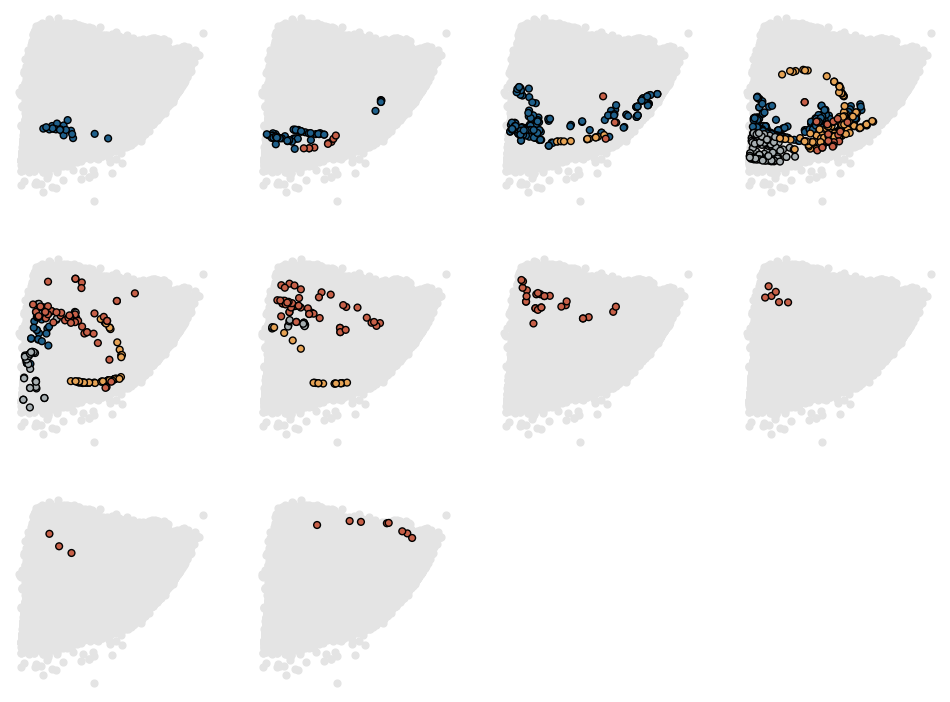

In [25]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

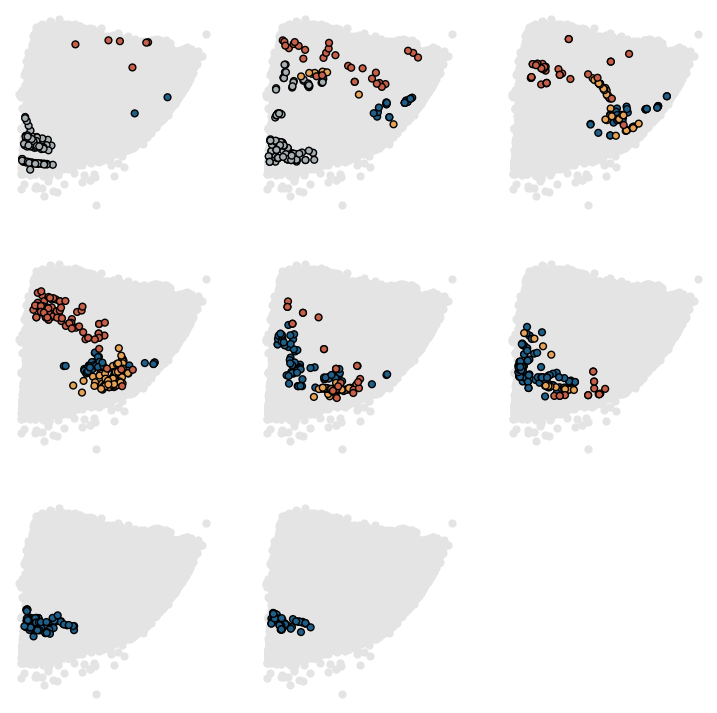

In [26]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1-2)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1-2)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

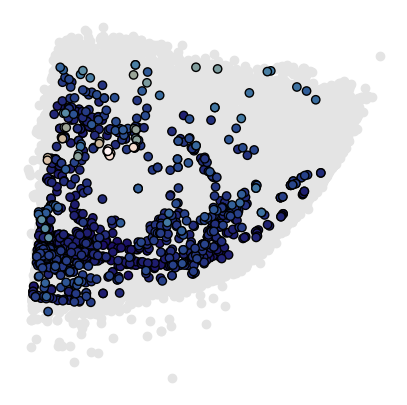

,formula,d_cdf_srt_l1,label,l,specie_src,specie_dst
1034,Zr2,0.306640,metallic,3.239225,Zr,Zr
1045,Zr2,0.316785,metallic,3.239226,Zr,Zr
1036,Zr2,0.318531,metallic,3.239235,Zr,Zr
1049,Zr2,0.326708,metallic,3.191473,Zr,Zr
1048,Zr2,0.328374,metallic,3.191476,Zr,Zr
1055,Zr2,0.329454,metallic,3.239225,Zr,Zr
1056,Zr2,0.334375,metallic,3.239235,Zr,Zr
1040,Zr2,0.342959,metallic,3.239238,Zr,Zr
1057,Zr2,0.345715,metallic,3.239226,Zr,Zr
1061,Zr2,0.356683,metallic,3.239238,Zr,Zr


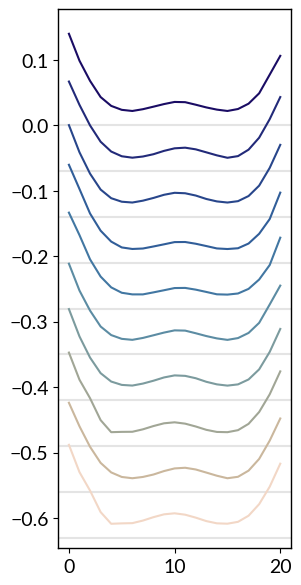

In [27]:
labeled.get_distances(ref=unlabeled, data='data_nodup', column='cdf_srt', metric='l1')
unlabeled.get_distances(ref=labeled, data='data_nodup', column='cdf_srt', metric='l1')

y = labeled.data_nodup['d_cdf_srt_l1'].values
order = np.argsort(y)
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.cmap, order=order)
plt.show()

n = 10
norm = plt.Normalize(vmin=0, vmax=n)
fig, ax = plt.subplots(figsize=(3,7))
for i, idx in enumerate(order[-n:]):
    ax.plot(derivative(range(len(labeled.data_nodup.iloc[0].elf)), labeled.data_nodup.iloc[idx]['cdf_srt']) - 0.07*i,
            color=model.cmap(norm(i)))
    ax.axhline(-0.07*i, color=model.bkg, zorder=-i)
    
labeled.data_nodup.iloc[order[-n:]][['formula', 'd_cdf_srt_l1', 'label', 'l', 'specie_src', 'specie_dst']]

#### Sorted CDFs of ELF profiles scaled by area

Number of components: 3


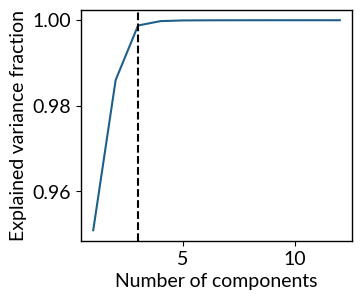

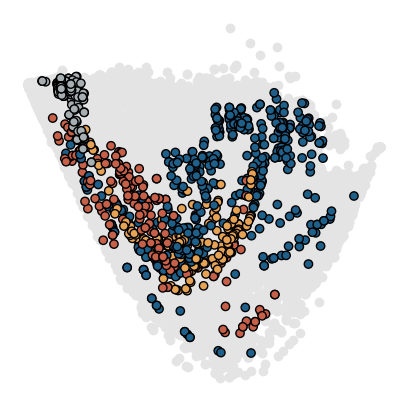

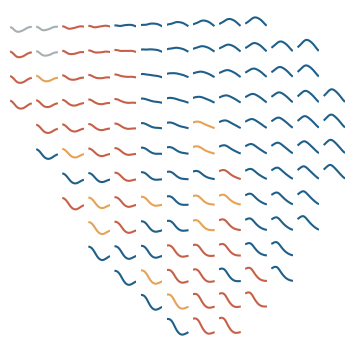

In [28]:
model = ELFModel(n_classes)

unlabeled.data_nodup['cdf-A_srt'] = unlabeled.data_nodup[['cdf_srt', 'A']].apply(lambda x: x.cdf_srt*x.A, axis=1)
labeled.data_nodup['cdf-A_srt'] = labeled.data_nodup[['cdf_srt', 'A']].apply(lambda x: x.cdf_srt*x.A, axis=1)

unlabeled.data_nodup = model.pca_fit(unlabeled.data_nodup, n_components, column='cdf-A_srt')
labeled.data_nodup = model.pca_transform(labeled.data_nodup)
fig = model.plot_evr(target=target)

y = model.bond_to_float(labeled.data_nodup['label'].tolist())
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.dmap)

derivative = lambda x, y: UnivariateSpline(x, y, k=4, s=0).derivative()(x)
fig = model.plot_profiles(n=15, axes=[0,1], y=y, cmap=model.dmap, transform=derivative)

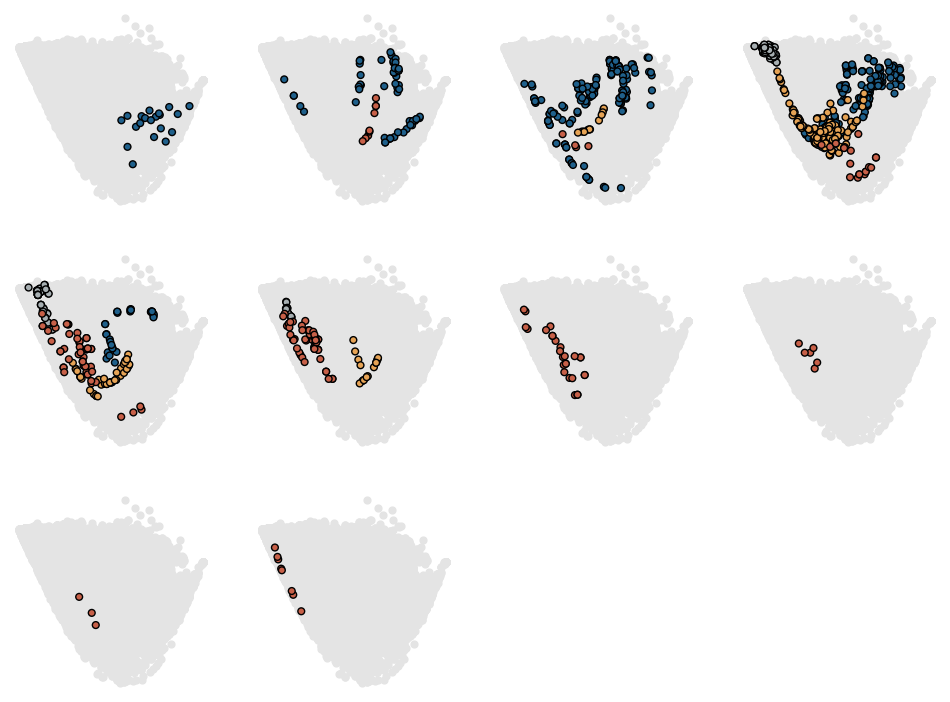

In [29]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['l_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

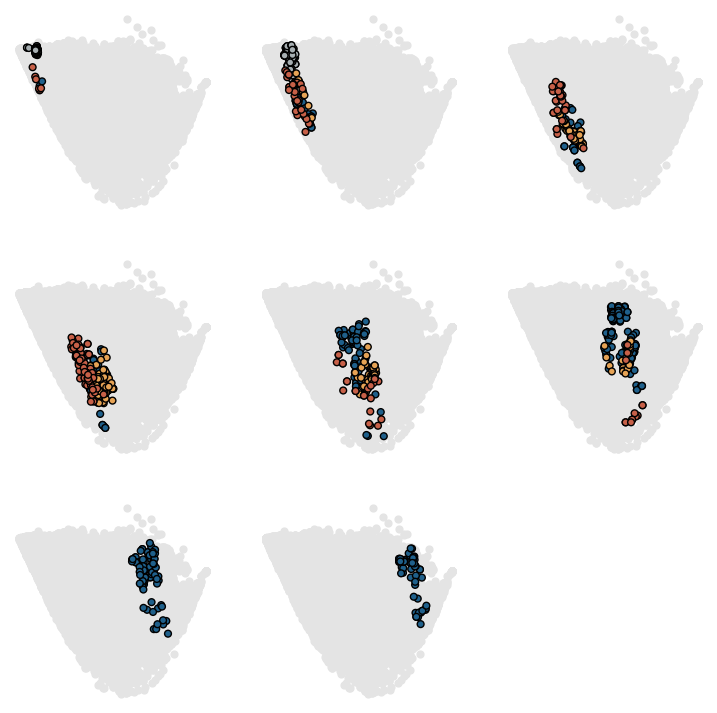

In [30]:
x = [np.stack(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'z_' + model.pca[0].column].values)
     for k in range(1,n_bins+1-2)]
y = [model.bond_to_float(labeled.data_nodup.loc[labeled.data_nodup['A_bin']==k, 'label'].tolist())
     for k in range(1,n_bins+1-2)]
fig = model.plot_projection_slices(x=x, y=y, axes=[0,1], cmap=model.dmap, order=True)

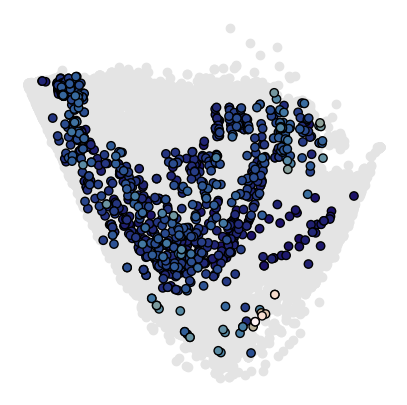

,formula,d_cdf-A_srt_l1,label,l,specie_src,specie_dst
112,C4,2.415184,covalent,1.424744,C,C
906,Si2,2.477730,covalent,2.368029,Si,Si
404,H2S_vdw,2.845481,vdw,2.691945,S,H
401,H2S_vdw,3.046067,vdw,2.691945,S,H
403,H2S_vdw,3.210414,vdw,2.691945,S,H
406,H2S_vdw,3.437289,vdw,2.691945,S,H
417,H2S_vdw,3.437289,vdw,2.691945,H,S
414,H2S_vdw,3.472853,vdw,2.749719,H,S
402,H2S_vdw,3.753858,vdw,2.691945,S,H
418,H2S_vdw,3.753858,vdw,2.691945,H,S


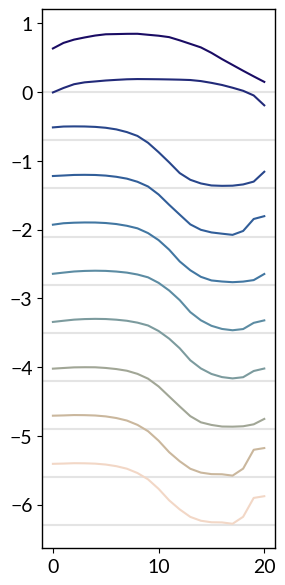

In [31]:
labeled.get_distances(ref=unlabeled, data='data_nodup', column='cdf-A_srt', metric='l1')
unlabeled.get_distances(ref=labeled, data='data_nodup', column='cdf-A_srt', metric='l1')

y = labeled.data_nodup['d_cdf-A_srt_l1'].values
order = np.argsort(y)
fig = model.plot_projection(axes=[0,1], y=y, cmap=model.cmap, order=order)
plt.show()

n = 10
norm = plt.Normalize(vmin=0, vmax=n)
fig, ax = plt.subplots(figsize=(3,7))
for i, idx in enumerate(order[-n:]):
    ax.plot(derivative(range(len(labeled.data_nodup.iloc[0].elf)), labeled.data_nodup.iloc[idx]['cdf-A_srt']) - 0.7*i,
            color=model.cmap(norm(i)))
    ax.axhline(-0.7*i, color=model.bkg, zorder=-i)
    
labeled.data_nodup.iloc[order[-n:]][['formula', 'd_cdf-A_srt_l1', 'label', 'l', 'specie_src', 'specie_dst']]

## Optimize hyperparameters

In [185]:
n_classes = 4
n_components = 10
#columns = [['elf_srt'], ['pdf_srt'], ['pdf-l_srt'], ['cdf_srt'], ['cdf-A_srt']]
columns = [['elf_srt','pdf_srt'], ['elf_srt','pdf-l_srt'], ['elf_srt','cdf_srt'], ['elf_srt','cdf-A_srt']]
features = [[], ['l'], ['A'], ['l', 'A']]

### Featurize data

In [186]:
models = []
for column in columns:
    models.append(ELFModel(n_classes))
    unlabeled.data_nodup = models[-1].pca_fit(unlabeled.data_nodup, n_components, column=column)

### Split data

In [187]:
test_size = 0.2
valid_size = 0.2

In [188]:
idx_train, idx_test = models[0].split(labeled.data_nodup, test_size, stratify=True)

y_train = models[0].bond_to_float(labeled.data_nodup.iloc[idx_train]['label'].tolist())
y_test = models[0].bond_to_float(labeled.data_nodup.iloc[idx_test]['label'].tolist())
class_weight = len(y_train)/(n_classes*np.bincount(y_train))

print('Train (Total):', len(idx_train), '\tTest:', len(idx_test))
print('Train (Bootstrap):', round((1 - valid_size)*len(idx_train)),
      '\tValid (Bootstrap):', round(valid_size*len(idx_train)))
print('Class weights:', list(class_weight))

Train (Total): 851 	Test: 213
Train (Bootstrap): 681 	Valid (Bootstrap): 170
Class weights: [0.5399746192893401, 1.3132716049382716, 1.4472789115646258, 1.4375]


### Train classifiers

In [189]:
n_estimators = np.arange(20, 205, 10)
max_depth = np.arange(8, 15, 2)
scores = np.zeros((len(columns), len(features), len(n_estimators), len(max_depth)))
oob_scores = np.zeros((len(columns), len(features), len(n_estimators), len(max_depth)))

In [190]:
for i in range(len(columns)):
    print(columns[i], ':', flush=True)
    inputs_list = [['z_' + k for k in columns[i]] + f for f in features]
    for j, inputs in enumerate(inputs_list):
        models[i].set_inputs(inputs)
        models[i].scaler_fit(unlabeled.data_nodup)
        models[i].prepare_inputs(labeled.data_nodup)

        x_train = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_train)
        x_test = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_test)

        for l, n in tqdm(enumerate(n_estimators), total=len(n_estimators), bar_format=labeled.bar_format):
            for m, d in enumerate(max_depth):
                models[i].clf_init(n, d, 1 - valid_size)
                models[i].clf.fit(x_train, y_train)
                scores[i,j,l,m] = models[i].clf.score(x_test, y_test, sample_weight=class_weight[y_test])
                oob_scores[i,j,l,m] = models[i].clf.oob_score_

['elf_srt', 'pdf_srt'] :


100%|██████████| 19/19 [00:15<00:00,  1.26it/s]                                 

['elf_srt', 'pdf-l_srt'] :



100%|██████████| 19/19 [00:15<00:00,  1.25it/s]                                 

['elf_srt', 'cdf_srt'] :



100%|██████████| 19/19 [00:14<00:00,  1.27it/s]                                 

['elf_srt', 'cdf-A_srt'] :



100%|██████████| 19/19 [00:15<00:00,  1.26it/s]                                 


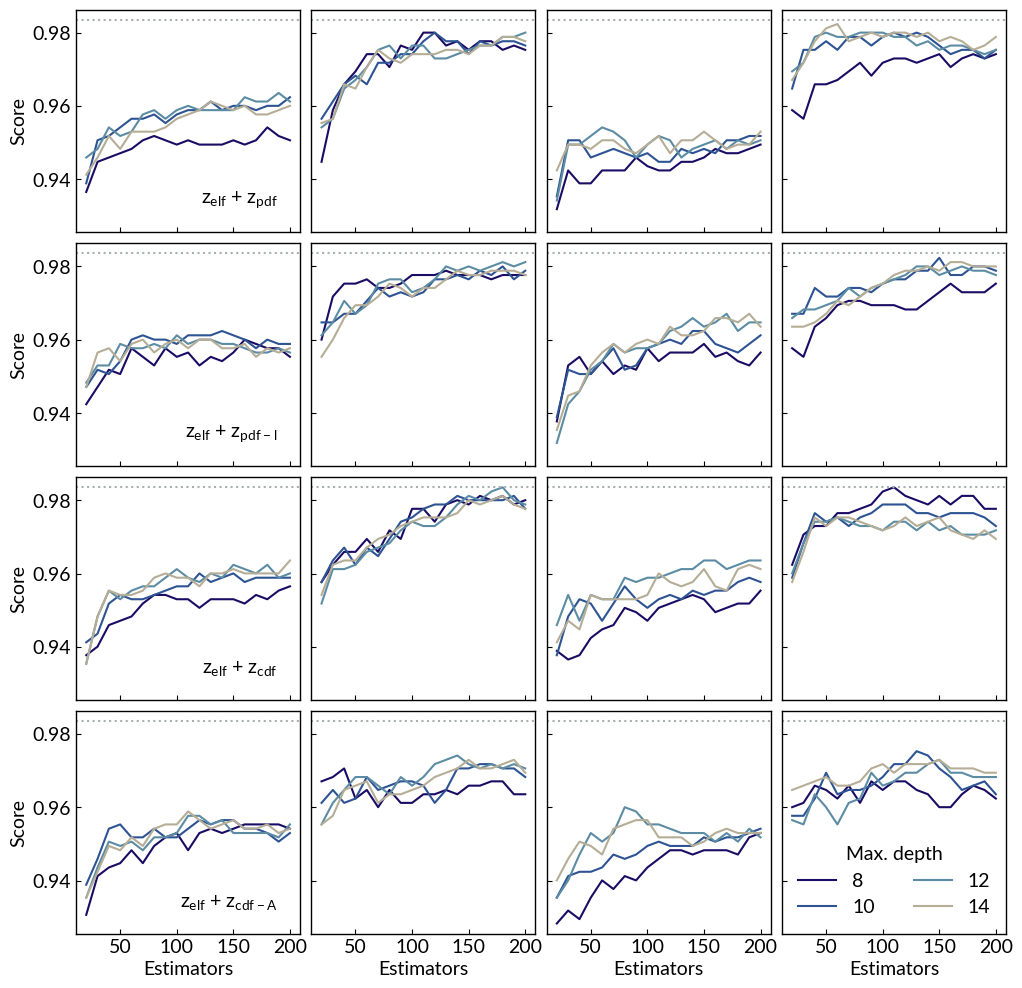

In [191]:
fig = models[0].plot_scores(oob_scores, columns, features, n_estimators, max_depth)

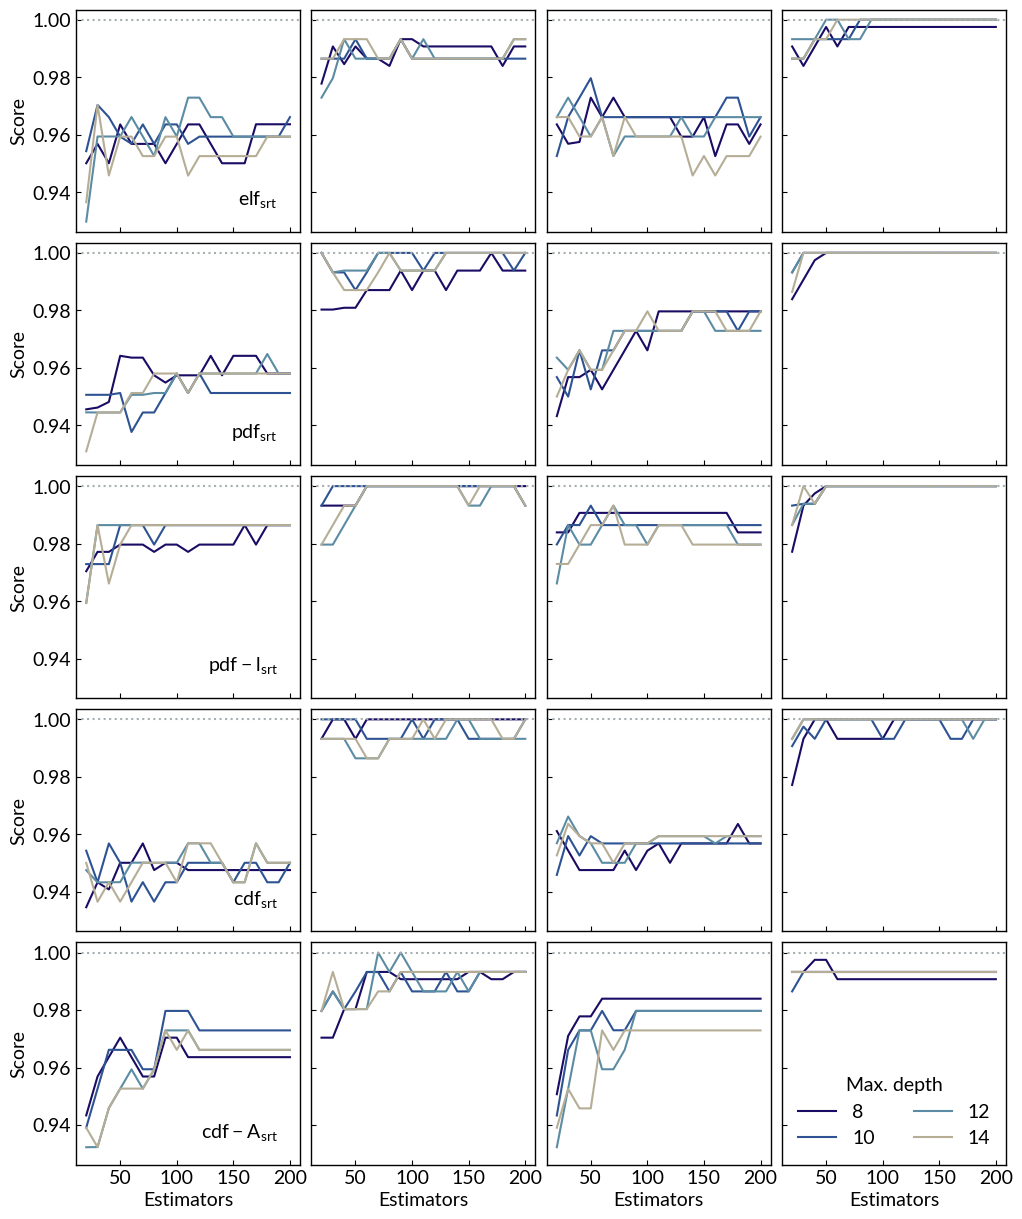

In [141]:
fig = models[0].plot_scores(scores, columns, features, n_estimators, max_depth)

## Train classifiers

In [32]:
savedir = 'models/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

In [147]:
n_classes = 4
n_components = 10
columns = [['elf_srt'], ['pdf_srt'], ['pdf-l_srt'], ['cdf_srt'], ['cdf-A_srt']]
features = ['l', 'A']

### Featurize data

In [148]:
models = []
for column in columns:
    models.append(ELFModel(n_classes))
    unlabeled.data_nodup = models[-1].pca_fit(unlabeled.data_nodup, n_components, column=column)

### Scale data

In [149]:
for i in range(len(models)):
    models[i].set_inputs(['z_' + k for k in columns[i]] + features)
    models[i].scaler_fit(unlabeled.data_nodup)

### Split data

In [150]:
test_size = 0.2
valid_size = 0.2

In [151]:
idx_train, idx_test = models[0].split(labeled.data_nodup, test_size, stratify=True)

y_train = models[0].bond_to_float(labeled.data_nodup.iloc[idx_train]['label'].tolist())
y_test = models[0].bond_to_float(labeled.data_nodup.iloc[idx_test]['label'].tolist())
class_weight = len(y_train)/(n_classes*np.bincount(y_train))

print('Train (Total):', len(idx_train), '\tTest:', len(idx_test))
print('Train (Bootstrap):', round((1 - valid_size)*len(idx_train)),
      '\tValid (Bootstrap):', round(valid_size*len(idx_train)))
print('Class weights:', list(class_weight))

Train (Total): 851 	Test: 213
Train (Bootstrap): 681 	Valid (Bootstrap): 170
Class weights: [0.5399746192893401, 1.3132716049382716, 1.4472789115646258, 1.4375]


### Train classifiers

In [174]:
n_estimators = 175
max_depth = 12
n_features = n_components*len(columns[0]) + len(features)
feature_importance = np.zeros((len(columns), n_features))
scores = np.zeros(len(columns))
oob_scores = np.zeros(len(columns))

In [175]:
for i in tqdm(range(len(columns)), bar_format=labeled.bar_format):
    models[i].prepare_inputs(labeled.data_nodup)
    x_train = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_train)
    x_test = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_test)
    
    models[i].clf_init(n_estimators, max_depth, 1 - valid_size)
    models[i].clf.fit(x_train, y_train)
    feature_importance[i,:] = models[i].clf.feature_importances_
    scores[i] = models[i].clf.score(x_test, y_test, sample_weight=class_weight[y_test])
    oob_scores[i] = models[i].clf.oob_score_

100%|██████████| 5/5 [00:01<00:00,  3.15it/s]                                   


In [176]:
_scores = np.zeros((len(columns), n_estimators))
for i in range(len(columns)):
    for j in range(n_estimators):
        _scores[i,j] = models[i].clf.estimators_[j].score(x_test, y_test, sample_weight=class_weight[y_test])

In [177]:
scores

array([1.        , 1.        , 1.        , 0.99322113, 0.99326693])

In [178]:
oob_scores

array([0.97414806, 0.98119859, 0.98589894, 0.97649824, 0.97767333])

[0.61420376 0.53896083 0.35795592 0.44459602 0.89974042]


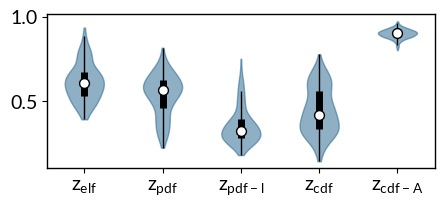

In [179]:
fig = models[0].plot_violins(_scores, columns)
print(_scores.mean(axis=-1))

In [180]:
_feature_importance = np.zeros((len(columns), n_estimators, n_features))
for i in range(len(columns)):
    for j in range(n_estimators):
        _feature_importance[i,j] = models[i].clf.estimators_[j].feature_importances_

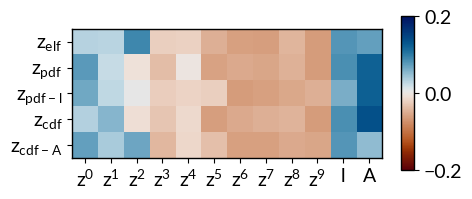

In [181]:
fig = models[0].plot_importances(feature_importance - 1./n_features,
                                 columns, features, vmin=-0.2, vmax=0.2, cmap=cm.vik_r)

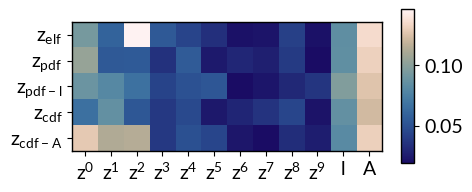

In [182]:
fig = models[0].plot_importances(_feature_importance.std(axis=1), columns, features)

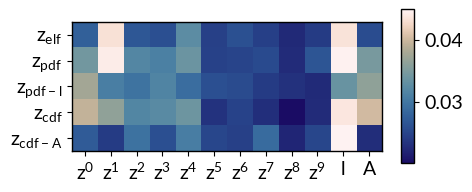

In [183]:
_feature_importance_cov = _feature_importance.mean(axis=1)/_feature_importance.std(axis=1)/(1 + 0.25*n_estimators)
fig = models[0].plot_importances(_feature_importance_cov, columns, features)

### Save models

In [184]:
if len(columns[0][0].split('_')) > 1:
    tag = '_' + columns[0][0].split('_')[-1]
else:
    tag = ''
        
for i in range(len(models)):
    column_name = '_'.join([''.join(k.split('_')[:-1]) for k in columns[i]]) + tag
    path = '_'.join([j + str(k) for (j,k) in zip(['c', 'z', 'n', 'd'],
                     [n_classes, n_components, n_estimators, max_depth])] + [column_name] + features)
    if center:
        path += '_cen'
        
    models[i].save_model(savedir + path)

## Cross-validate

In [365]:
n_classes = 3
n_components = 10
columns = [['elf_srt'], ['pdf_srt'], ['pdf-l_srt'], ['cdf_srt'], ['cdf-A_srt']]
features = ['l','A']

### Featurize data

In [366]:
models = []
for column in columns:
    models.append(ELFModel(n_classes))
    unlabeled.data_nodup = models[-1].pca_fit(unlabeled.data_nodup, n_components, column=column)

### Scale data

In [367]:
for i in range(len(models)):
    models[i].set_inputs(['z_' + k for k in columns[i]] + features)
    models[i].scaler_fit(unlabeled.data_nodup)

### Split data

In [368]:
test_size = 0.2
valid_size = 0.2
n_folds = 10
kfold = models[0].split_kfold(n_folds, test_size)

### Train classifiers

In [369]:
n_estimators = 175
max_depth = 12
n_features = n_components*len(columns[0]) + len(features)
scores = np.zeros((len(columns), n_folds))

In [370]:
y = models[0].bond_to_float(labeled.data_nodup['label'].tolist())

for i in tqdm(range(len(columns)), bar_format=labeled.bar_format):
    models[i].prepare_inputs(labeled.data_nodup)
    
    for j, (idx_train, idx_test) in enumerate(kfold.split(np.zeros(len(y)), y)):
        x_train = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_train)
        x_test = models[i].get_columns(labeled.data_nodup, ['inputs_scaled'], idx_test)
        y_train = y[idx_train]
        y_test = y[idx_test]
        class_weight = len(y_train)/(n_classes*np.bincount(y_train))
        
        models[i].clf_init(n_estimators, max_depth, 1 - valid_size)
        models[i].clf.fit(x_train, y_train)
        scores[i,j] = models[i].clf.score(x_test, y_test, sample_weight=class_weight[y_test])

100%|██████████| 5/5 [00:14<00:00,  2.83s/it]                                   


[0.98880413 0.99080703 0.9912574  0.9856357  0.98668468]


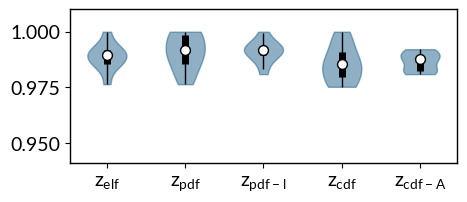

In [110]:
fig = models[0].plot_violins(scores, columns)
plt.ylim([0.941,1.01])
print(scores.mean(axis=-1))